# Final Project Quantitative Macroeconomics:

## Part 1: Solving McCall's Model of Intertemporal Search. 

#### Jorge Batanero Rodríguez

In [19]:
import numpy as np
from numba import jit, jitclass, float64
from numba.experimental import jitclass
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

###  Model

I'm going to introduce the theoretical framework of the McCall's model. In this model we focus in an unemployed worker who is searching for job. Each period that he search the is a new job offer, that offers a wage $\omega$. The worker has two alternatives, he can reject the job and wait until the next period to recieve a new job offer, in that case he will recieve a compensation c in this period, that is going to be exogenous determine in this model, or he can accept the job, in which case he or she receives the wage $\omega$ forever, in this simple model there is no option to quit or to get fired.


Let $y_t$ be the income in period t. Therefore $y_t=c$ if he is unemployed and $y_t=\omega$ if he is employed. The unemployed worker want to maximice $\mathbb{E}\sum_{t=0}^\infty \beta^t y_t$ where $\beta \in (0,1)$ is the discount factor.

The wage offer is going to be a nonnegative function of some underlying state:

\begin{align*}
    \omega_t=\omega(s_t) \quad \text{where} \quad s_t \in S
\end{align*}

Where $s_t$ is going to be a realization of a shock that affects the wages, in this case is going to be assume that $s_t$ are iid, with q(s) as the probability of observing state s. The worker observes $s_t$ at the begging of period t, therefore he knows $\omega_t$.

The worker face a trade off between accepting too soon or waiting too much, waiting too long is costly, since the future is discounted. Accepting too soon is also costly, since better offers can arrive in the future.

Therefore the value function of an unemployed worker is given by:

\begin{align}
    v(s)=max \left\{ \frac{\omega(s)}{1-\beta}, c+\beta \sum_{s' \in S} v(s')q(s') \right\}
\end{align}

Where $\frac{\omega(s)}{1-\beta}$ is the lifetime payoff of accepting the job for a wage $\omega(s)$ at a state s, and $c+\beta \sum_{s' \in S} v(s')q(s')$ is the lifetime payoff of rejecting the job and then behaving optimally in all subsequent periods. 

A solution to this problem is a policy function, that maps states into actions, that is for every posible state s gives the optimal behavior. We can write the policy function as follows:

\begin{align}
    \sigma(s):= 1\left\{\frac{\omega(s)}{1-\beta}\ge c+\beta \sum_{s' \in S} v(s')q(s') \right\}
\end{align}

Where $1\{X\}=1$ if statement X is true and 0 otherwise. 

From the previous equation we can isolate $\omega(s)=\bar{\omega}$ to get the reservation wage, that is the threshold for accepting or rejecting an offer. We can define the reservation wage as follows

\begin{align}
    \bar{\omega}:=(1-\beta)\left\{c+\beta\sum_{s'}v(s')q(s')\right\}
\end{align}



### Algorithm

I need to compute the value function at each possible state $s \in S$. For $S=\{1,\dots,n\}$.

The value function is then represented by the vector $v = (v(𝑖))_{𝑖=1}^n$.

Step 1: pick an arbitrary initial guess $v\in \mathbb{R}^n$.

Step 2: compute a new vector $v' \in \mathbb{R}^n$

\begin{align}
    v'(i)=max\left\{ \frac{\omega(i)}{1-\beta}, c+\beta \sum_{1\le j \le n} v(j)q(j)\right\} \quad \text{for} \quad i=1, \dots, n
\end{align}

Step 3: calculate a measure of the deviation between $v$ and $v'$, such as $max_𝑖 |v(𝑖) − v′(𝑖)|$.

Step 4: if the deviation is larger than some fixed tolerance, set $v = v′$ and go to step 2, else
continue.

Step 5: return $v$.


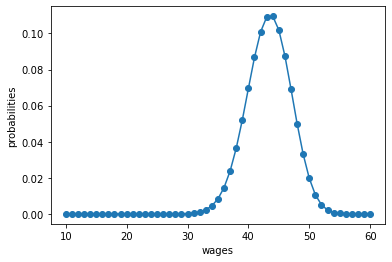

In [8]:
# The distribution for the state process is assume to be a Beta-binomial

n, a, b= 50, 200, 100 # Parameters of the distribution
q=BetaBinomial(n, a, b).pdf()

# Now I set all the possible values for the wage

w_min=10 # min value for the wage
w_max=60 # max value for the wage
wage=np.linspace(w_min, w_max, n+1)

# Now we can plot the probability of receiving an offer for each wage

fig, ax = plt.subplots()
ax.plot(wage, q, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
plt.show()


In [9]:
model_data = [
('c', float64), # unemployment compensation
('β', float64), # discount factor
('w', float64[:]), # array of wage values, w[i] = wage at state i
('q', float64[:]) # array of probabilities
]

# Using jit (Just In Time) we accelerate the code
@jitclass(model_data)
class McCallModel:
    
    def __init__(self, c=25, β=0.99, w=wage, q=q):
        
        self.c = c
        self.β= β
        self.q = q
        self.w = wage
        
    def state_values(self, i, v):
        """
        The values of state-action pairs.
        """
        c, β, w, q = self.c, self.β, self.w, self.q
        # Two possible action for every state accept or reject
        accept = w[i]/(1-β)
        reject = c + β*np.sum(v * q)
        
        return np.array([accept, reject])
    
        

In [16]:
def plot_value_function_seq(mcm, ax, num_plots=5):
    """
    Plot a sequence of value functions.
    * mcm is an instance of McCallModel, it will allow to call the function
     and simplify the notation.
    * ax is an axes object that implements a plot method.
    """
    n = len(mcm.w) # length of v
    v = mcm.w / (1 - mcm.β) # Initial guess
    v_next = np.empty_like(v) # Create a empty vector with the same len as v
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            # use the previous function to decide whether accept or rejects
            v_next[i] = np.max(mcm.state_values(i, v)) 
        v[:] = v_next # copy contents into v
    ax.legend(loc='lower right')

In the following graph we can see how the convergence is happening, for every iteration the value function is getting closer.

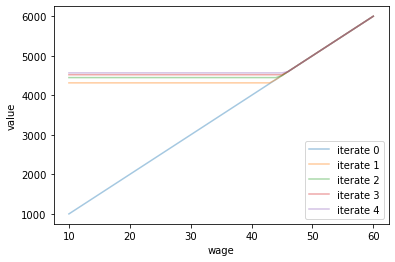

In [18]:
mcm = McCallModel()
# Here I use the function previously created to plot the iteration of value functions

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

Another interesting exercise is to calculate the reservation wage, for the initial values of the proposed parametrization and then since it only depends on the discount factor and the compensation for being unemployed c, we can change this parameters and see how does the reservation wage change.

In [26]:
# First we compute the Reservation wage

def reservation_wage(mcm, maxitera=500, ε=1e-6):
    
    # Change names to simplify the notation
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q
    # First we compute the value function as before
    n = len(w)
    v = w / (1 - β) # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = ε + 1
    while i < maxitera and error > ε:
        for i in range(n):
            v_next[i]=np.max(mcm.state_values(i, v))
        error = np.max(np.abs(v_next-v))
        i +=1
        
        v[:]= v_next # copy v_next into v for the new iteration
        
    # Now compute the reservation wage
    return (1-β)*(c+β*np.sum(v*q))

reservation_wage(mcm)

47.31649971002494

In [28]:
# Now we can plot a similar graph to the one that we used in PS2
# in the COVID model to see how does the reservation wage change 
# when we change c or β

grid_size=25
R_wage = np.empty((grid_size, grid_size)) # Return matrix of reservation wages

c_grid=np.linspace(10,30,grid_size)
β_grid=np.linspace(0.10, 0.99, grid_size)
# Computing the different values for the reservation wage
# for each combination of c and β
for i, c in enumerate(c_grid):
    for j, β in enumerate(β_grid):
        mcm=McCallModel(c=c, β=β)
        R_wage[i,j]=reservation_wage(mcm)


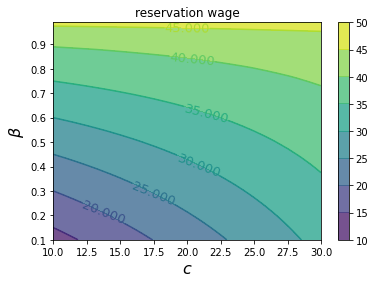

In [30]:
# Plot of the Reservation Wage for the different values of c and β

fig, ax = plt.subplots()
cs1 = ax.contourf(c_grid, β_grid, R_wage.T, alpha=0.75)
ctr1 = ax.contour(c_grid, β_grid, R_wage.T)
plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)
ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)
ax.ticklabel_format(useOffset=False)
plt.show()